In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My Drive/PROJECT - NLP/semantic-segmentation/data/text/files

/content/drive/My Drive/PROJECT - NLP/semantic-segmentation/data/text/files


In [0]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [0]:
import os
import io
import re
import pandas as pd

In [0]:
sent = []
classes = []
sent1 = []
sent2 = []

for filename in os.listdir():
  with io.open(filename,'r') as f:
    file = f.read()
  for i in range(len(file.split('\n'))):
    if len(file.split('\n')[i].split('\t')) == 2:
      s = file.split('\n')[i].split('\t')[0]
      #s = re.sub(r'[^\w\s]','',s)
      sent.append(s)
      doc = nlp(s)
      for X in doc.ents:
        s = s.replace(X.text,X.label_)
      sent1.append(s.replace(X.text,X.label_))
      classes.append(file.split('\n')[i].split('\t')[1])

dic = {'Sentence':sent,'Sent_NER':sent1,'Class':classes}
df = pd.DataFrame(dic)

In [0]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(classes)

LabelEncoder()

In [0]:
enc.classes_

array(['Argument', 'Facts', 'Precedent', 'Ratio of the decision',
       'Ruling by Lower Court', 'Ruling by Present Court', 'Statute'],
      dtype='<U23')

In [0]:
classes = enc.transform(classes)

In [0]:
df = pd.concat([df,pd.DataFrame(list(classes))],axis = 1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


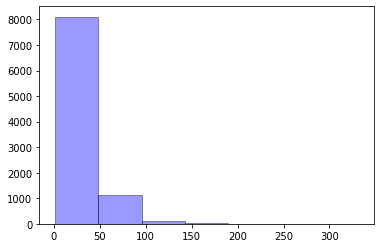

In [0]:
max_len = []
for X in df['Sentence']:
  max_len.append(len(X.split()))
import seaborn as sns
sns.distplot(max_len, hist=True, kde=False,bins=int(7), color = 'blue',hist_kws={'edgecolor':'black'})

In [0]:
isLong = []
for X in df['Sent_NER']:
  if len(X.split()) >= 130:
    isLong.append(True)
  else:
    isLong.append(False)
df['isLong'] = pd.DataFrame(isLong)

In [0]:
df.columns = ['Sentence','Sent_NER','Classes','Label','isLong']
df.to_csv('file2.csv')

In [0]:
df = pd.read_csv('file2.csv')

In [0]:
print(len(df[df['isLong'] == True]))
df_1 = df[df['isLong'] == False]

39


In [0]:
!pip install transformers

     |████████████████████████████████| 573kB 15.7MB/s 
     |████████████████████████████████| 3.7MB 34.6MB/s 
     |████████████████████████████████| 890kB 40.2MB/s 
     |████████████████████████████████| 1.0MB 44.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=4d9e5453456fc00157d56d442cfb5fe39dde86af7c3e8b933556f6baf93dbc73
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [0]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [0]:
sentences = df_1.Sent_NER.values
labels = df_1.Label.values

In [0]:
print(' Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  This appeal with special leave is directed against the judgment and order of ORG in a dispute regarding the workers' claim for bonus
Tokenized:  ['this', 'appeal', 'with', 'special', 'leave', 'is', 'directed', 'against', 'the', 'judgment', 'and', 'order', 'of', 'org', 'in', 'a', 'dispute', 'regarding', 'the', 'workers', "'", 'claim', 'for', 'bonus']
Token IDs:  [2023, 5574, 2007, 2569, 2681, 2003, 2856, 2114, 1996, 8689, 1998, 2344, 1997, 8917, 1999, 1037, 7593, 4953, 1996, 3667, 1005, 4366, 2005, 6781]


In [0]:
max_len = 0
for sent in sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len,len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  202


In [0]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [0]:
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )   
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  This appeal with special leave is directed against the judgment and order of ORG in a dispute regarding the workers' claim for bonus
Token IDs: tensor([ 101, 2023, 5574, 2007, 2569, 2681, 2003, 2856, 2114, 1996, 8689, 1998,
        2344, 1997, 8917, 1999, 1037, 7593, 4953, 1996, 3667, 1005, 4366, 2005,
        6781,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [0]:
from torch.utils.data import TensorDataset, random_split
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

8,405 training samples
  934 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 7,   
    output_attentions = False,
    output_hidden_states = False,
)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
from transformers import get_linear_schedule_with_warmup

epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [0]:
CUDA_LAUNCH_BLOCKING=1

In [0]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch    40  of    263.    Elapsed: 0:00:17.
  Batch    80  of    263.    Elapsed: 0:00:33.
  Batch   120  of    263.    Elapsed: 0:00:50.
  Batch   160  of    263.    Elapsed: 0:01:06.
  Batch   200  of    263.    Elapsed: 0:01:23.
  Batch   240  of    263.    Elapsed: 0:01:40.

  Average training loss: 1.40
  Training epcoh took: 0:01:49

Running Validation...
  Accuracy: 0.57
  Validation Loss: 1.22
  Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    263.    Elapsed: 0:00:17.
  Batch    80  of    263.    Elapsed: 0:00:34.
  Batch   120  of    263.    Elapsed: 0:00:51.
  Batch   160  of    263.    Elapsed: 0:01:08.
  Batch   200  of    263.    Elapsed: 0:01:25.
  Batch   240  of    263.    Elapsed: 0:01:42.

  Average training loss: 1.11
  Training epcoh took: 0:01:52

Running Validation...
  Accuracy: 0.59
  Validation Loss: 1.14
  Validation took: 0:00:04

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    263.    Elapsed: 0:00:1

In [0]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.40,1.22,0.57,0:01:49,0:00:04
2,1.11,1.14,0.59,0:01:52,0:00:04
3,0.94,1.07,0.62,0:01:53,0:00:04
4,0.82,1.08,0.63,0:01:53,0:00:04


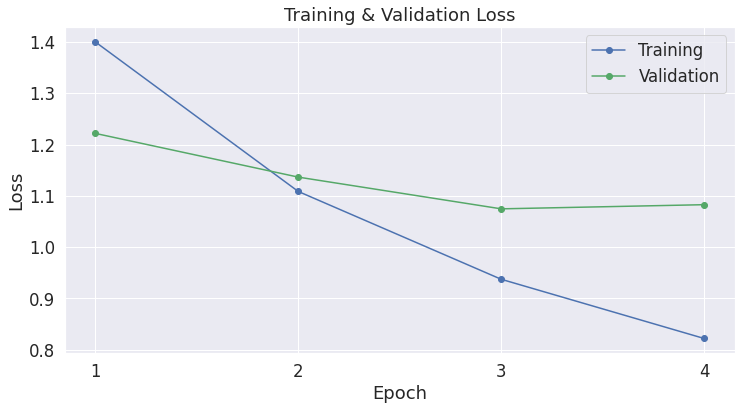

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [0]:
preds_labels = []
l = len(input_ids)
for i in range(l):
  t = model(input_ids[i].unsqueeze(0).cuda(), attention_mask=attention_masks[i].unsqueeze(0).cuda(),labels=labels[i].unsqueeze(0).cuda())[1]
  preds_labels.append(np.argmax(t.detach().cpu().numpy()))

In [0]:
from sklearn.metrics import classification_report
dic = classification_report(labels,preds_labels, labels=[0,1,2,3,4,5,6], target_names=['Argument', 'Facts', 'Precedent', 'Ratio of the decision','Ruling by Lower Court', 'Ruling by Present Court', 'Statute'], digits=2, output_dict=True, zero_division='warn')
print(dic)
df_report = pd.DataFrame(data = dic)

{'Argument': {'precision': 0.7665369649805448, 'recall': 0.46904761904761905, 'f1-score': 0.5819793205317577, 'support': 840}, 'Facts': {'precision': 0.7956817273090764, 'recall': 0.8984198645598194, 'f1-score': 0.8439355385920272, 'support': 2215}, 'Precedent': {'precision': 0.7119932432432432, 'recall': 0.5762132604237867, 'f1-score': 0.6369474877219493, 'support': 1463}, 'Ratio of the decision': {'precision': 0.726399625204966, 'recall': 0.8571033720287452, 'f1-score': 0.7863572968175478, 'support': 3618}, 'Ruling by Lower Court': {'precision': 0.8260869565217391, 'recall': 0.06070287539936102, 'f1-score': 0.11309523809523808, 'support': 313}, 'Ruling by Present Court': {'precision': 0.7718446601941747, 'recall': 0.6068702290076335, 'f1-score': 0.6794871794871795, 'support': 262}, 'Statute': {'precision': 0.8317757009345794, 'recall': 0.8503184713375797, 'f1-score': 0.8409448818897638, 'support': 628}, 'accuracy': 0.7538280329799765, 'macro avg': {'precision': 0.7757598397697605, 'r

In [0]:
df_report

,Argument,Facts,Precedent,Ratio of the decision,Ruling by Lower Court,Ruling by Present Court,Statute,accuracy,macro avg,weighted avg
precision,0.77,0.80,0.71,0.73,0.83,0.77,0.83,0.75,0.78,0.76
recall,0.47,0.90,0.58,0.86,0.06,0.61,0.85,0.75,0.62,0.75
f1-score,0.58,0.84,0.64,0.79,0.11,0.68,0.84,0.75,0.64,0.74
support,840.00,2215.00,1463.00,3618.00,313.00,262.00,628.00,0.75,9339.00,9339.00
